#  Modeling Protein-Ligand Interactions with Atomic Convolutions
By [Nathan C. Frey](https://ncfrey.github.io/) | [Twitter](https://twitter.com/nc_frey) and [Bharath Ramsundar](https://rbharath.github.io/) | [Twitter](https://twitter.com/rbhar90)

This DeepChem tutorial introduces the [Atomic Convolutional Neural Network](https://arxiv.org/pdf/1703.10603.pdf). We'll see the structure of the `AtomicConvModel` and write a simple program to run Atomic Convolutions.

### ACNN Architecture
ACNN’s directly exploit the local three-dimensional structure of molecules to hierarchically learn more complex chemical features by optimizing both the model and featurization simultaneously in an end-to-end fashion.

The atom type convolution makes use of a neighbor-listed distance matrix to extract features encoding local chemical environments from an input representation (Cartesian atomic coordinates) that does not necessarily contain spatial locality. The following methods are used to build the ACNN architecture:

- __Distance Matrix__  
The distance matrix $R$ is constructed from the Cartesian atomic coordinates $X$. It calculates distances from the distance tensor $D$. The distance matrix construction accepts as input a $(N, 3)$ coordinate matrix $C$. This matrix is “neighbor listed” into a $(N, M)$ matrix $R$.

```python
    R = tf.reduce_sum(tf.multiply(D, D), 3)     # D: Distance Tensor
    R = tf.sqrt(R)                              # R: Distance Matrix
    return R
```

- **Atom type convolution**  
The output of the atom type convolution is constructed from the distance matrix $R$ and atomic number matrix $Z$. The matrix $R$ is fed into a (1x1) filter with stride 1 and depth of $N_{at}$ , where $N_{at}$ is the number of unique atomic numbers (atom types) present in the molecular system. The atom type convolution kernel is a step function that operates on the neighbor distance matrix $R$.

- **Radial Pooling layer**  
Radial Pooling is basically a dimensionality reduction process that down-samples the output of the atom type convolutions. The reduction process prevents overfitting by providing an abstracted form of representation through feature binning, as well as reducing the number of parameters learned.
Mathematically, radial pooling layers pool over tensor slices (receptive fields) of size (1x$M$x1) with stride 1 and a depth of $N_r$, where $N_r$ is the number of desired radial filters and $M$ is the maximum number of neighbors.

- **Atomistic fully connected network**  
Atomic Convolution layers are stacked by feeding the flattened ($N$, $N_{at}$ $\cdot$ $N_r$) output of the radial pooling layer into the atom type convolution operation. Finally, we feed the tensor row-wise (per-atom) into a fully-connected network. The
same fully connected weights and biases are used for each atom in a given molecule.

Now that we have seen the structural overview of ACNNs, we'll try to get deeper into the model and see how we can train it and what we expect as the output.

For the training, we will use the publicly available PDBbind dataset. In this example, every row reflects a protein-ligand complex and the target is the binding affinity ($K_i$) of the ligand to the protein in the complex.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Modeling_Protein_Ligand_Interactions_With_Atomic_Convolutions.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [1]:
# # Download Miniconda if not already installed
# wget https://repo.anaconda.com/miniconda/Miniconda3-latest-MacOSX-x86_64.sh
# bash Miniconda3-latest-MacOSX-x86_64.sh

# # Then create a conda env
# conda create -n atomic python=3.10
# conda activate atomic
# conda install -c conda-forge pycosat mdtraj pdbfixer openmm


In [2]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

  Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mdtraj 1.10.3 requires netCDF4, which is not installed.
qiskit-machine-learning 0.8.3 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
/Users/sanskriti/miniconda3/envs/atomic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models

'2.8.1.dev'

In [3]:
 ##you need to use conda for tensorflow.in your terminal
# conda install -c conda-forge tensorflow 

import deepchem as dc
import os

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from rdkit import Chem

from deepchem.molnet import load_pdbbind
from deepchem.models import AtomicConvModel
from deepchem.feat import AtomicConvFeaturizer

### Getting protein-ligand data
If you worked through [Tutorial 13](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Modeling_Protein_Ligand_Interactions.ipynb) on modeling protein-ligand interactions, you'll already be familiar with how to obtain a set of data from PDBbind for training our model. Since we explored molecular complexes in detail in the [previous tutorial]((https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Modeling_Protein_Ligand_Interactions.ipynb)), this time we'll simply initialize an `AtomicConvFeaturizer` and load the PDBbind dataset directly using MolNet.

In [4]:
f1_num_atoms = 100  # maximum number of atoms to consider in the ligand
f2_num_atoms = 1000  # maximum number of atoms to consider in the protein
max_num_neighbors = 12  # maximum number of spatial neighbors for an atom

acf = AtomicConvFeaturizer(frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      neighbor_cutoff=4)

`load_pdbbind` allows us to specify if we want to use the entire protein or only the binding pocket (`pocket=True`) for featurization. Using only the pocket saves memory and speeds up the featurization. We can also use the "core" dataset of ~200 high-quality complexes for rapidly testing our model, or the larger "refined" set of nearly 5000 complexes for more datapoints and more robust training/validation. On Colab, it takes only a minute to featurize the core PDBbind set! This is pretty incredible, and it means you can quickly experiment with different featurizations and model architectures.

In [5]:
%%time
tasks, datasets, transformers = load_pdbbind(featurizer=acf,
                                             save_dir='.',
                                             data_dir='.',
                                             pocket=True,
                                             reload=False,
                                             set_name='core')

[23:08:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:08:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:08:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:08:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:08:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:08:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:08:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:08:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:08:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

CPU times: user 17.7 s, sys: 2.95 s, total: 20.6 s
Wall time: 19.7 s


Unfortunately, if you try to use the "refined" dataset, there are some complexes that cannot be featurized. To resolve this issue, rather than increasing `complex_num_atoms`, simply omit the lines of the dataset that have an `x` value of `None`

In [6]:
class MyTransformer(dc.trans.Transformer):
  def transform_array(x, y, w, ids):
    kept_rows = np.array([xi is not None for xi in x])
    return x[kept_rows], y[kept_rows], w[kept_rows], ids[kept_rows]

datasets = [d.transform(MyTransformer) for d in datasets]

In [7]:
datasets

[<DiskDataset X.shape: (154, 9), y.shape: (154,), w.shape: (154,), ids: ['3uo4' '2jdm' '1jyq' ... '3l4w' '2cbj' '3f80'], task_names: [0]>,
 <DiskDataset X.shape: (19, 9), y.shape: (19,), w.shape: (19,), ids: ['1lbk' '2obf' '1f8c' ... '2p4y' '3g0w' '3nox'], task_names: [0]>,
 <DiskDataset X.shape: (20, 9), y.shape: (20,), w.shape: (20,), ids: ['2yge' '1q8u' '1w3l' ... '1p1q' '2x97' '1oyt'], task_names: [0]>]

In [8]:
train, val, test = datasets

In [9]:
## remember to do this in terminal: pip install --upgrade git+https://github.com/deepchem/deepchem.git
import deepchem
print(deepchem.models.atomic_conv.__file__)

/Users/sanskriti/miniconda3/envs/atomic/lib/python3.10/site-packages/deepchem/models/atomic_conv.py


In [10]:
from deepchem.models import AtomicConvModel

model = AtomicConvModel(
    n_tasks=1,
    frag1_num_atoms=70,
    frag2_num_atoms=60,
    complex_num_atoms=130,
    max_num_neighbors=4,
    batch_size=4,
    layer_sizes=[32, 32, 16],
    learning_rate=0.001
)


### Training the model

Now that we've got our dataset, let's go ahead and initialize an `AtomicConvModel` to train. Keep the input parameters the same as those used in `AtomicConvFeaturizer`, or else we'll get errors. `layer_sizes` controls the number of layers and the size of each dense layer in the network. We choose these hyperparameters to be the same as those used in the [original paper](https://arxiv.org/pdf/1703.10603.pdf).

In [11]:
acm = AtomicConvModel(n_tasks=1,
                      frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      batch_size=12,
                      layer_sizes=[32, 32, 16],
                      learning_rate=0.003,
                      )

In [12]:
losses, val_losses = [], []

In [34]:
# %%time
# max_epochs = 50

# metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
# step_cutoff = len(train)//12
# def val_cb(model, step):
#   if step%step_cutoff!=0:
#       return
#   val_losses.append(model.evaluate(val, metrics=[metric])['rms_score']**2)  # L2 Loss
#   losses.append(model.evaluate(train, metrics=[metric])['rms_score']**2)  # L2 Loss

# acm.fit(train, nb_epoch=max_epochs, max_checkpoints_to_keep=1,
#                 callbacks=[val_cb])

CPU times: user 21min 44s, sys: 20min 31s, total: 42min 15s
Wall time: 5min 11s


0.4295252215477728

In [ ]:
# %%time
# max_epochs = 50

# val_losses = []
# losses = []
# step_cutoff = len(train) // 12

# def val_cb(model, step):
#     # Only print every step_cutoff steps
#     if step % step_cutoff != 0:
#         return
#     epoch = step // step_cutoff
#     train_loss = model.evaluate(train, metrics=[metric])['rms_score']**2
#     val_loss = model.evaluate(val, metrics=[metric])['rms_score']**2
#     losses.append(train_loss)
#     val_losses.append(val_loss)
#     print(f"Epoch {epoch}/{max_epochs}: Train Loss (L2) = {train_loss:.4f}, Val Loss (L2) = {val_loss:.4f}")
# acm.fit(train, nb_epoch=max_epochs, max_checkpoints_to_keep=1,
#                 callbacks=[val_cb])

The loss curves are not exactly smooth, which is unsurprising because we are using 154 training and 19 validation datapoints. Increasing the dataset size may help with this, but will also require greater computational resources.

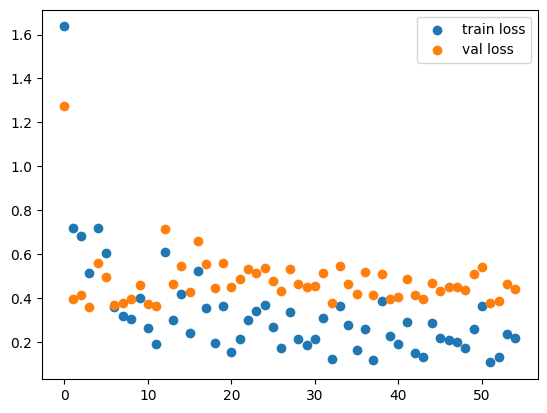

In [35]:
f, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')
plt.legend(loc='upper right');

The [ACNN paper](https://arxiv.org/pdf/1703.10603.pdf) showed a Pearson $R^2$ score of 0.912 and 0.448 for a random 80/20 split of the PDBbind core train/test sets. Here, we've used an 80/10/10 training/validation/test split and achieved similar performance for the training set (0.943). We can see from the performance on the training, validation, and test sets (and from the results in the paper) that the ACNN can learn chemical interactions from small training datasets, but struggles to generalize. Still, it is pretty amazing that we can train an `AtomicConvModel` with only a few lines of code and start predicting binding affinities!  
From here, you can experiment with different hyperparameters, more challenging splits, and the "refined" set of PDBbind to see if you can reduce overfitting and come up with a more robust model.

In [36]:
score = dc.metrics.Metric(dc.metrics.score_function.pearson_r2_score)
for tvt, ds in zip(['train', 'val', 'test'], datasets):
  print(tvt, acm.evaluate(ds, metrics=[score]))

train {'pearson_r2_score': 0.9334718872066573}
val {'pearson_r2_score': 0.492220227105845}
test {'pearson_r2_score': 0.3820186925594279}


In [ ]:
import numpy as np

predicted = acm.predict(val)  # shape: (n_samples, 1)
actual = val.y  # shape: (n_samples,)

# Flatten predictions if needed
predicted = predicted.flatten()

# Display a few values
for i in range(min(10, len(actual))):
    print(f"Actual: {actual[i]:.4f}, Predicted: {predicted[i]:.4f}")


Actual: 1.0371, Predicted: 0.4835
Actual: 2.1097, Predicted: 1.3458
Actual: -0.4690, Predicted: -0.6806
Actual: -0.3027, Predicted: 0.4518
Actual: -0.0706, Predicted: 0.0807
Actual: 0.2359, Predicted: 0.3877
Actual: -0.3289, Predicted: 1.0871
Actual: -1.7781, Predicted: -0.9164
Actual: -0.2458, Predicted: -0.1711
Actual: 0.7131, Predicted: 0.4641


### Further reading
We have explored the ACNN architecture and used the PDBbind dataset to train an ACNN to predict protein-ligand binding energies. For more information, read the original paper that introduced ACNNs: Gomes, Joseph, et al. "Atomic convolutional networks for predicting protein-ligand binding affinity." [arXiv preprint arXiv:1703.10603](https://arxiv.org/abs/1703.10603) (2017). There are many other methods and papers on predicting binding affinities. Here are a few interesting ones to check out: predictions using [only ligands or proteins](https://www.frontiersin.org/articles/10.3389/fphar.2020.00069/full), [molecular docking with deep learning](https://chemrxiv.org/articles/preprint/GNINA_1_0_Molecular_Docking_with_Deep_Learning/13578140), and [AtomNet](https://arxiv.org/abs/1510.02855).

In [37]:
from qiskit.primitives import Estimator, Sampler
from qiskit_machine_learning.algorithms import VQR


## Quantum stuff

In [38]:
# 1) IMPORTS & DATA LOADING
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from deepchem.molnet import load_pdbbind
# Qiskit ML pieces
from qiskit.circuit.library import ZFeatureMap
from qiskit_machine_learning.algorithms import VQR
from qiskit.primitives import Estimator
from scipy.optimize import minimize

# 2) LOAD DEEPCHEM DATA
# (assumes you've already run your AtomicConvFeaturizer load & MyTransformer steps)
tasks, datasets, transformers = load_pdbbind(
    featurizer=acf,
    save_dir='.',
    data_dir='.',
    pocket=True,
    reload=False,
    set_name='core'
)
train, val, test = datasets
X_train_dc, y_train = train.X, train.y
X_val_dc,   y_val   = val.X,   val.y
X_test_dc,  y_test  = test.X,  test.y

[23:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:34:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

In [39]:


# 3) FLATTEN DeepChem FEATURES → CLASSICAL MATRIX
def flatten_dc_features(X_dc):
    rows = []
    for sample in X_dc:
        pieces = []
        for comp in sample:
            # only flatten real numpy arrays
            if isinstance(comp, np.ndarray):
                pieces.append(comp.ravel())
        # join all the numeric pieces
        vec = np.concatenate(pieces)
        rows.append(vec)
    # make into one (n_samples, n_features) float64 array
    flat = np.vstack(rows).astype(np.float64)
    return flat

# then:
X_train_flat = flatten_dc_features(X_train_dc)
print("train flat:", X_train_flat.shape, X_train_flat.dtype)
X_val_flat   = flatten_dc_features(X_val_dc)
X_test_flat  = flatten_dc_features(X_test_dc)


# 4) SCALE + PCA → N‐QUBIT INPUT VECTORS
n_qubits = 6  # pick based on your simulator capacity
# scale into [−π,π] so feature_map rotations stay numeric
fm_scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_all = fm_scaler.fit_transform(
    np.vstack([X_train_flat, X_val_flat, X_test_flat])
)
pca = PCA(n_components=n_qubits)
X_all_pca = pca.fit_transform(X_all)

# split back
N_train = X_train_flat.shape[0]
N_val   = X_val_flat.shape[0]
X_train_pca = X_all_pca[:N_train]
X_val_pca   = X_all_pca[N_train:N_train+N_val]
X_test_pca  = X_all_pca[N_train+N_val:]

# scale targets y into [−1,+1] for single‐qubit range
y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_all = y_scaler.fit_transform(
    np.vstack([y_train.reshape(-1,1), y_val.reshape(-1,1), y_test.reshape(-1,1)])
)
y_train_scaled = y_all[:N_train].ravel()
y_val_scaled   = y_all[N_train:N_train+N_val].ravel()
y_test_scaled  = y_all[N_train+N_val:].ravel()

# 5) BUILD THE QCNN CIRCUIT
# 5.1 Feature map
feature_map = ZFeatureMap(feature_dimension=n_qubits, reps=1)

# 5.2 A simple “1‐conv + 1‐pool” QCNN block for illustration
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def conv_instruction(n, prefix):
    params = ParameterVector(prefix, length=3*n)
    qc = QuantumCircuit(n, name="Conv")
    idx = 0
    for q1,q2 in zip(range(0,n,2), range(1,n,2)):
        sub = QuantumCircuit(2)
        sub.rz(-np.pi/2, 1)
        sub.cx(1,0)
        sub.rz(params[idx],   0)
        sub.ry(params[idx+1], 1)
        sub.cx(0,1)
        sub.ry(params[idx+2], 1)
        qc.compose(sub, [q1,q2], inplace=True)
        qc.barrier()
        idx += 3
    return qc.to_instruction()

def pool_instruction(srcs, sinks, prefix):
    params = ParameterVector(prefix, length=3*len(srcs))
    n = len(srcs)+len(sinks)
    qc = QuantumCircuit(n, name="Pool")
    idx = 0
    for s,t in zip(srcs, sinks):
        sub = QuantumCircuit(2)
        sub.rz(-np.pi/2, 1)
        sub.cx(1,0)
        sub.rz(params[idx],   0)
        sub.ry(params[idx+1], 1)
        sub.cx(0,1)
        sub.ry(params[idx+2], 1)
        qc.compose(sub, [s,t], inplace=True)
        qc.barrier()
        idx += 3
    return qc.to_instruction()

# Assemble: fmap → conv → pool → measure Z⊗… at end
qc_cnn = QuantumCircuit(n_qubits)
# qc_cnn.compose(feature_map, range(n_qubits), inplace=True)
qc_cnn.append(conv_instruction(n_qubits, "c1"), range(n_qubits))
# example pooling halving qubits [0→n/2],[1→n/2+1],…
src = list(range(0,n_qubits,2))
snk = list(range(1,n_qubits,2))
qc_cnn.append(pool_instruction(src, snk, "p1"), range(n_qubits))
# now only n_qubits/2 logical remain; you’d repeat conv+pool until 1 remains


def lbfgs_b_opt(fun, x0, jac=None, bounds=None):
    return minimize(
        fun,
        x0,
        method="L-BFGS-B",
        jac=jac,
        bounds=bounds,
        options={"maxiter": 150},
    )


# 6) WRAP IN A VQR & TRAIN
vqr = VQR(
    num_qubits=n_qubits,
    feature_map=feature_map,
    ansatz=qc_cnn,
    optimizer=lbfgs_b_opt,
    estimator=Estimator(),
)

# fit on train, validate on val
vqr.fit(X_train_pca, y_train_scaled)
y_val_pred_scaled = vqr.predict(X_val_pca)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1,1)).ravel()

# 7) EVALUATE ON TEST
y_test_pred_scaled = vqr.predict(X_test_pca)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1,1)).ravel()

# Now you have y_test_pred in the original binding‐energy units!


train flat: (154, 8800) float64


/var/folders/9z/tkcd7rfx1bxd05989nnkhc7r0000gn/T/ipykernel_18074/2971493220.py:121: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator=Estimator(),


In [40]:
### testing
print([row.shape for row in X_train_flat[:5]])
print(np.array(X_train_flat).dtype)


[(8800,), (8800,), (8800,), (8800,), (8800,)]
float64


In [41]:
import pandas as pd

df = pd.DataFrame({
    "Actual":    y_test,
    "Predicted": y_test_pred
})
print(df)


      Actual  Predicted
0  -1.283395   0.072756
1   1.260367   0.254306
2  -0.162564   0.176979
3  -0.661684   0.181123
4   0.682438   0.382338
5   0.958268   0.131388
6  -0.832436   0.444012
7   0.354069   0.312787
8  -0.631036  -0.441948
9   0.170183  -0.080742
10  0.809407   0.077081
11  0.629899   0.175521
12  0.739355   0.224675
13 -0.477798   0.217159
14 -0.114403   0.217620
15 -1.795650   0.150069
16  0.257748   0.071144
17  0.152670   0.347913
18  0.980159   0.215037
19  2.070342   0.152179


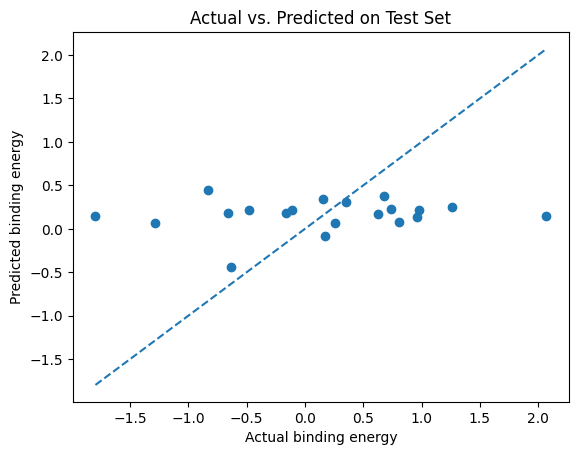

In [42]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         ls="--")  # diagonal line
plt.xlabel("Actual binding energy")
plt.ylabel("Predicted binding energy")
plt.title("Actual vs. Predicted on Test Set")
plt.show()


## hybrid

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Sampler

# ← Use SamplerQNN directly from its submodule
from qiskit_machine_learning.neural_networks.sampler_qnn import SamplerQNN  # :contentReference[oaicite:0]{index=0}
from qiskit_machine_learning.connectors.torch_connector import TorchConnector

# 1) HYPERPARAMETERS
n_qubits      = 6
batch_size    = 16
learning_rate = 1e-3
n_epochs      = 50
D             = X_train_flat.shape[1]   # total # of classical features

# 2) BUILD THE QUANTUM LAYER
feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=1)
ansatz      = RealAmplitudes(num_qubits=n_qubits, reps=1)
qc_circuit  = feature_map.compose(ansatz)

sampler     = Sampler()
# create a SamplerQNN with the right input/weight params and output size
sampler_qnn = SamplerQNN(
    circuit=qc_circuit,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    sampler=sampler,
    output_shape=1
)
quantum_layer = TorchConnector(sampler_qnn)

# 3) DEFINE THE HYBRID 1D‐CNN
class HybridCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool1d(2)
        self.fc1   = nn.Linear(32 * (D//2), n_qubits)
        self.qc    = quantum_layer
        self.fc2   = nn.Linear(1, 1)

    def forward(self, x):
        x = x.unsqueeze(1)            # (batch, D) → (batch,1,D)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)     # → (batch, 32*(D/2))
        x = self.fc1(x)               # → (batch, n_qubits)
        x = self.qc(x)                # → (batch,1)
        x = self.fc2(x)               # → (batch,1)
        return x.squeeze(-1)          # → (batch,)

# 4) CREATE DATALOADERS
train_ds = TensorDataset(
    torch.tensor(X_train_flat, dtype=torch.float32),
    torch.tensor(y_train_scaled, dtype=torch.float32)
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_ds = TensorDataset(
    torch.tensor(X_val_flat, dtype=torch.float32),
    torch.tensor(y_val_scaled, dtype=torch.float32)
)
val_loader = DataLoader(val_ds, batch_size=batch_size)

# 5) TRAIN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = HybridCNN().to(device)
opt    = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

for epoch in range(1, n_epochs+1):
    model.train()
    train_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = loss_fn(model(Xb), yb)
        loss.backward()
        opt.step()
        train_loss += loss.item()*Xb.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            val_loss += loss_fn(model(Xb), yb).item()*Xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:3d}  Train MSE: {train_loss:.4f}  Val MSE: {val_loss:.4f}")

# 6) TEST
model.eval()
X_test_t = torch.tensor(X_test_flat, dtype=torch.float32).to(device)
with torch.no_grad():
    y_test_pred_scaled = model(X_test_t).cpu().numpy()
y_test_pred = y_scaler.inverse_transform(
    y_test_pred_scaled.reshape(-1,1)
).ravel()
print("Test predictions:", y_test_pred)


/var/folders/9z/tkcd7rfx1bxd05989nnkhc7r0000gn/T/ipykernel_18074/3208322058.py:25: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler     = Sampler()
/var/folders/9z/tkcd7rfx1bxd05989nnkhc7r0000gn/T/ipykernel_18074/3208322058.py:27: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x64 and 1x1)